# Neural Relational Inference for Interacting Systems
Author: Jin Yeom (jinyeom@utexas.edu)

This notebook attempts to understand [this paper](https://arxiv.org/abs/1802.04687) (Kipf et al., 2018) by implementing the Neural Relational Inference (NRI) algorithm with PyTorch. Note that code for generating data is imported from the paper's [original implementation](https://github.com/hudl/relational-inference).

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# from https://github.com/hudl/relational-inference/blob/master/data/synthetic_sim.py

class SpringSim(object):
    def __init__(self, 
                 n_balls: int = 5, 
                 box_size: float = 5.0, 
                 loc_std: float = 0.5, 
                 vel_norm: float = 0.5,
                 interaction_strength: float = 0.1, 
                 noise_var: float = 0.0):
        self.n_balls = n_balls
        self.box_size = box_size
        self.loc_std = loc_std
        self.vel_norm = vel_norm
        self.interaction_strength = interaction_strength
        self.noise_var = noise_var

        self._spring_types = np.array([0., 0.5, 1.])
        self._delta_T = 0.001
        self._max_F = 0.1 / self._delta_T

    def _energy(self, loc, vel, edges):
        # disables division by zero warning, since I fix it with fill_diagonal
        with np.errstate(divide='ignore'):
            K = 0.5 * (vel ** 2).sum()
            U = 0
            for i in range(loc.shape[1]):
                for j in range(loc.shape[1]):
                    if i != j:
                        r = loc[:, i] - loc[:, j]
                        dist = np.sqrt((r ** 2).sum())
                        U += 0.5 * self.interaction_strength * edges[
                            i, j] * (dist ** 2) / 2
            return U + K

    def _clamp(self, loc, vel):
        '''
        :param loc: 2xN location at one time stamp
        :param vel: 2xN velocity at one time stamp
        :return: location and velocity after hiting walls and returning after
            elastically colliding with walls
        '''
        assert (np.all(loc < self.box_size * 3))
        assert (np.all(loc > -self.box_size * 3))

        over = loc > self.box_size
        loc[over] = 2 * self.box_size - loc[over]
        assert (np.all(loc <= self.box_size))

        # assert(np.all(vel[over]>0))
        vel[over] = -np.abs(vel[over])

        under = loc < -self.box_size
        loc[under] = -2 * self.box_size - loc[under]
        # assert (np.all(vel[under] < 0))
        assert (np.all(loc >= -self.box_size))
        vel[under] = np.abs(vel[under])

        return loc, vel

    def _l2(self, A, B):
        """
        Input: A is a Nxd matrix
               B is a Mxd matirx
        Output: dist is a NxM matrix where dist[i,j] is the square norm
            between A[i,:] and B[j,:]
        i.e. dist[i,j] = ||A[i,:]-B[j,:]||^2
        """
        A_norm = (A ** 2).sum(axis=1).reshape(A.shape[0], 1)
        B_norm = (B ** 2).sum(axis=1).reshape(1, B.shape[0])
        dist = A_norm + B_norm - 2 * A.dot(B.transpose())
        return dist

    def sample_trajectory(self, 
                          T=10000, 
                          sample_freq=10,
                          spring_prob=[1. / 2, 0, 1. / 2]):
        n = self.n_balls
        assert (T % sample_freq == 0)
        T_save = int(T / sample_freq - 1)
        diag_mask = np.ones((n, n), dtype=bool)
        np.fill_diagonal(diag_mask, 0)
        counter = 0
        # Sample edges
        edges = np.random.choice(self._spring_types,
                                 size=(self.n_balls, self.n_balls),
                                 p=spring_prob)
        edges = np.tril(edges) + np.tril(edges, -1).T
        np.fill_diagonal(edges, 0)
        # Initialize location and velocity
        loc = np.zeros((T_save, 2, n))
        vel = np.zeros((T_save, 2, n))
        loc_next = np.random.randn(2, n) * self.loc_std
        vel_next = np.random.randn(2, n)
        v_norm = np.sqrt((vel_next ** 2).sum(axis=0)).reshape(1, -1)
        vel_next = vel_next * self.vel_norm / v_norm
        loc[0, :, :], vel[0, :, :] = self._clamp(loc_next, vel_next)

        # disables division by zero warning, since I fix it with fill_diagonal
        with np.errstate(divide='ignore'):

            forces_size = - self.interaction_strength * edges
            np.fill_diagonal(forces_size,
                             0)  # self forces are zero (fixes division by zero)
            F = (forces_size.reshape(1, n, n) *
                 np.concatenate((
                     np.subtract.outer(loc_next[0, :],
                                       loc_next[0, :]).reshape(1, n, n),
                     np.subtract.outer(loc_next[1, :],
                                       loc_next[1, :]).reshape(1, n, n)))).sum(
                axis=-1)
            F[F > self._max_F] = self._max_F
            F[F < -self._max_F] = -self._max_F

            vel_next += self._delta_T * F
            # run leapfrog
            for i in range(1, T):
                loc_next += self._delta_T * vel_next
                loc_next, vel_next = self._clamp(loc_next, vel_next)

                if i % sample_freq == 0:
                    loc[counter, :, :], vel[counter, :, :] = loc_next, vel_next
                    counter += 1

                forces_size = - self.interaction_strength * edges
                np.fill_diagonal(forces_size, 0)
                # assert (np.abs(forces_size[diag_mask]).min() > 1e-10)

                F = (forces_size.reshape(1, n, n) *
                     np.concatenate((
                         np.subtract.outer(loc_next[0, :],
                                           loc_next[0, :]).reshape(1, n, n),
                         np.subtract.outer(loc_next[1, :],
                                           loc_next[1, :]).reshape(1, n,
                                                                   n)))).sum(
                    axis=-1)
                F[F > self._max_F] = self._max_F
                F[F < -self._max_F] = -self._max_F
                vel_next += self._delta_T * F
            # Add noise to observations
            loc += np.random.randn(T_save, 2, self.n_balls) * self.noise_var
            vel += np.random.randn(T_save, 2, self.n_balls) * self.noise_var
            return loc, vel, edges

[[0. 1. 1. 1. 0.]
 [1. 0. 1. 1. 0.]
 [1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Simulation time: 0.26683616638183594


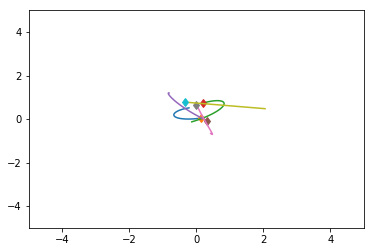

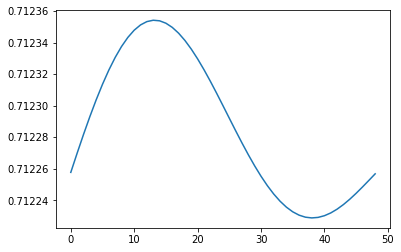

In [19]:
sim = SpringSim()

t = time.time()

loc, vel, edges = sim.sample_trajectory(T=5000, sample_freq=100)

print(edges)
print("Simulation time: {}".format(time.time() - t))
vel_norm = np.sqrt((vel ** 2).sum(axis=1))
plt.figure()
axes = plt.gca()
axes.set_xlim([-5., 5.])
axes.set_ylim([-5., 5.])
for i in range(loc.shape[-1]):
    plt.plot(loc[:, 0, i], loc[:, 1, i])
    plt.plot(loc[0, 0, i], loc[0, 1, i], 'd')
plt.figure()
energies = [sim._energy(loc[i, :, :], vel[i, :, :], edges) for i in
            range(loc.shape[0])]
plt.plot(energies)
plt.show()

In [17]:
# from https://github.com/hudl/relational-inference/blob/master/data/synthetic_sim.py

class ChargedParticlesSim(object):
    def __init__(self, n_balls=5, box_size=5., loc_std=1., vel_norm=0.5,
                 interaction_strength=1., noise_var=0.):
        self.n_balls = n_balls
        self.box_size = box_size
        self.loc_std = loc_std
        self.vel_norm = vel_norm
        self.interaction_strength = interaction_strength
        self.noise_var = noise_var

        self._charge_types = np.array([-1., 0., 1.])
        self._delta_T = 0.001
        self._max_F = 0.1 / self._delta_T

    def _l2(self, A, B):
        """
        Input: A is a Nxd matrix
               B is a Mxd matirx
        Output: dist is a NxM matrix where dist[i,j] is the square norm
            between A[i,:] and B[j,:]
        i.e. dist[i,j] = ||A[i,:]-B[j,:]||^2
        """
        A_norm = (A ** 2).sum(axis=1).reshape(A.shape[0], 1)
        B_norm = (B ** 2).sum(axis=1).reshape(1, B.shape[0])
        dist = A_norm + B_norm - 2 * A.dot(B.transpose())
        return dist

    def _energy(self, loc, vel, edges):

        # disables division by zero warning, since I fix it with fill_diagonal
        with np.errstate(divide='ignore'):

            K = 0.5 * (vel ** 2).sum()
            U = 0
            for i in range(loc.shape[1]):
                for j in range(loc.shape[1]):
                    if i != j:
                        r = loc[:, i] - loc[:, j]
                        dist = np.sqrt((r ** 2).sum())
                        U += 0.5 * self.interaction_strength * edges[
                            i, j] / dist
            return U + K

    def _clamp(self, loc, vel):
        '''
        :param loc: 2xN location at one time stamp
        :param vel: 2xN velocity at one time stamp
        :return: location and velocity after hiting walls and returning after
            elastically colliding with walls
        '''
        assert (np.all(loc < self.box_size * 3))
        assert (np.all(loc > -self.box_size * 3))

        over = loc > self.box_size
        loc[over] = 2 * self.box_size - loc[over]
        assert (np.all(loc <= self.box_size))

        # assert(np.all(vel[over]>0))
        vel[over] = -np.abs(vel[over])

        under = loc < -self.box_size
        loc[under] = -2 * self.box_size - loc[under]
        # assert (np.all(vel[under] < 0))
        assert (np.all(loc >= -self.box_size))
        vel[under] = np.abs(vel[under])

        return loc, vel

    def sample_trajectory(self, T=10000, sample_freq=10,
                          charge_prob=[1. / 2, 0, 1. / 2]):
        n = self.n_balls
        assert (T % sample_freq == 0)
        T_save = int(T / sample_freq - 1)
        diag_mask = np.ones((n, n), dtype=bool)
        np.fill_diagonal(diag_mask, 0)
        counter = 0
        # Sample edges
        charges = np.random.choice(self._charge_types, size=(self.n_balls, 1),
                                   p=charge_prob)
        edges = charges.dot(charges.transpose())
        # Initialize location and velocity
        loc = np.zeros((T_save, 2, n))
        vel = np.zeros((T_save, 2, n))
        loc_next = np.random.randn(2, n) * self.loc_std
        vel_next = np.random.randn(2, n)
        v_norm = np.sqrt((vel_next ** 2).sum(axis=0)).reshape(1, -1)
        vel_next = vel_next * self.vel_norm / v_norm
        loc[0, :, :], vel[0, :, :] = self._clamp(loc_next, vel_next)

        # disables division by zero warning, since I fix it with fill_diagonal
        with np.errstate(divide='ignore'):
            # half step leapfrog
            l2_dist_power3 = np.power(
                self._l2(loc_next.transpose(), loc_next.transpose()), 3. / 2.)

            # size of forces up to a 1/|r| factor
            # since I later multiply by an unnormalized r vector
            forces_size = self.interaction_strength * edges / l2_dist_power3
            np.fill_diagonal(forces_size,
                             0)  # self forces are zero (fixes division by zero)
            assert (np.abs(forces_size[diag_mask]).min() > 1e-10)
            F = (forces_size.reshape(1, n, n) *
                 np.concatenate((
                     np.subtract.outer(loc_next[0, :],
                                       loc_next[0, :]).reshape(1, n, n),
                     np.subtract.outer(loc_next[1, :],
                                       loc_next[1, :]).reshape(1, n, n)))).sum(
                axis=-1)
            F[F > self._max_F] = self._max_F
            F[F < -self._max_F] = -self._max_F

            vel_next += self._delta_T * F
            # run leapfrog
            for i in range(1, T):
                loc_next += self._delta_T * vel_next
                loc_next, vel_next = self._clamp(loc_next, vel_next)

                if i % sample_freq == 0:
                    loc[counter, :, :], vel[counter, :, :] = loc_next, vel_next
                    counter += 1

                l2_dist_power3 = np.power(
                    self._l2(loc_next.transpose(), loc_next.transpose()),
                    3. / 2.)
                forces_size = self.interaction_strength * edges / l2_dist_power3
                np.fill_diagonal(forces_size, 0)
                # assert (np.abs(forces_size[diag_mask]).min() > 1e-10)

                F = (forces_size.reshape(1, n, n) *
                     np.concatenate((
                         np.subtract.outer(loc_next[0, :],
                                           loc_next[0, :]).reshape(1, n, n),
                         np.subtract.outer(loc_next[1, :],
                                           loc_next[1, :]).reshape(1, n,
                                                                   n)))).sum(
                    axis=-1)
                F[F > self._max_F] = self._max_F
                F[F < -self._max_F] = -self._max_F
                vel_next += self._delta_T * F
            # Add noise to observations
            loc += np.random.randn(T_save, 2, self.n_balls) * self.noise_var
            vel += np.random.randn(T_save, 2, self.n_balls) * self.noise_var
            return loc, vel, edges

/Users/jinseok.yeom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in power


[[ 1. -1. -1. -1.  1.]
 [-1.  1.  1.  1. -1.]
 [-1.  1.  1.  1. -1.]
 [-1.  1.  1.  1. -1.]
 [ 1. -1. -1. -1.  1.]]
Simulation time: 0.4794890880584717


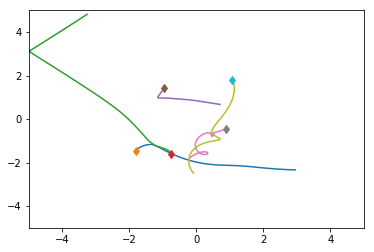

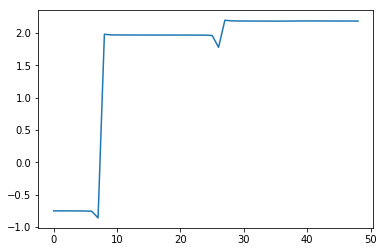

In [18]:
sim = ChargedParticlesSim()

t = time.time()

loc, vel, edges = sim.sample_trajectory(T=5000, sample_freq=100)

print(edges)
print("Simulation time: {}".format(time.time() - t))
vel_norm = np.sqrt((vel ** 2).sum(axis=1))
plt.figure()
axes = plt.gca()
axes.set_xlim([-5., 5.])
axes.set_ylim([-5., 5.])
for i in range(loc.shape[-1]):
    plt.plot(loc[:, 0, i], loc[:, 1, i])
    plt.plot(loc[0, 0, i], loc[0, 1, i], 'd')
plt.figure()
energies = [sim._energy(loc[i, :, :], vel[i, :, :], edges) for i in
            range(loc.shape[0])]
plt.plot(energies)
plt.show()

## References
- arXiv:1802.04687v2 \[stat.ML\]